### Import Library

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from sklearn.metrics import classification_report

from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, Conv1D, Conv2D, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from keras import optimizers

np.random.seed(0)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

#PW: added warning ignore
import warnings
warnings.filterwarnings('ignore')

C:\Users\wang_\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Import Data

In [3]:
# Here we extract the data files (NOTE: please enter data path)
path_train = 'C:/Users/wang_/Dropbox/PAULINE/Berkeley_MIDS/W207_Applied_ML/Project_Facial/training.csv'
path_test = 'C:/Users/wang_/Dropbox/PAULINE/Berkeley_MIDS/W207_Applied_ML/Project_Facial/test.csv'

df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [4]:
# Processing training data such that each pixel has its own column and is seperated from the labels
kaggle_train = df_train.loc[:,'Image'].T
kaggle_train = kaggle_train.astype(str)
kaggle_train = kaggle_train.str.split(" ", expand = True) 

image_test = df_test.loc[:,'Image'].T
image_test = image_test.astype(str)
image_test = image_test.str.split(" ", expand = True)
kaggle_test = pd.DataFrame(df_test.loc[:,'ImageId']).join(image_test)
labels = df_train.iloc[:, 0:30] 

### Michael's model 

In [5]:
# MB: Model based on Todd's example + wrapper KerasRegressor
kaggle_train = kaggle_train.astype(int)
X_train = kaggle_train / 255.
y_train = labels

print(X_train.shape)
print(y_train.shape)

(7049, 9216)
(7049, 30)


In [6]:
# Remove observations with missing values
index_none_missing = np.sum(np.isfinite(y_train), axis = 1) == y_train.shape[1]
X_train = np.asarray(X_train.loc[index_none_missing,:])
y_train = np.asarray(labels.loc[index_none_missing,:])

# Preparing use of training data for conv layer
train_data = X_train.reshape(X_train.shape[0], 96, 96, 1)

In [7]:
print(train_data.shape)
print(y_train.shape)

(2140, 96, 96, 1)
(2140, 30)


In [8]:
from keras import backend
from keras.wrappers.scikit_learn import KerasRegressor

# custom defined RMSE loss metric as by https://stackoverflow.com/questions/43855162/rmse-rmsle-loss-function-in-keras
# top 10 score < 1.74, top 50 < 2.298, top 100 < 3.65
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true)))

# R squared as reporting metric, defined as by https://github.com/keras-team/keras/issues/7947
def r_square(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + backend.epsilon()) )

def baseline_model():
    model = Sequential()

    #model.add(Conv2D(64, kernel_size=4, activation='relu', input_shape=(96,96,1)))
    #model.add(MaxPool2D((2, 2)))

    #model.add(Conv2D(32, (3, 3), activation='relu',padding='same', kernel_initializer='he_normal'))
    #model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())

    #model.add(Dropout(0.1, input_shape=(9216,)))

    model.add(Dense(200, input_dim=9216, activation='relu'))
    model.add(Dense(100, input_dim=200, activation='softmax'))
    model.add(Dense(30, input_dim=100, kernel_initializer = 'normal'))

    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(optimizer=sgd, loss='mse', metrics=['mse', r_square, rmse])
    
    return model

# for Keras regressor see: https://keras.io/scikit-learn-api/
estimator = KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=10)
history = estimator.fit(train_data, y_train, validation_split=0.2, shuffle=True)

Train on 1712 samples, validate on 428 samples
Epoch 1/50
1712/1712 [==============================] - 6s 4ms/step - loss: 658.3464 - mean_squared_error: 658.3464 - r_square: -0.8695 - rmse: 21.3777 - val_loss: 40.7369 - val_mean_squared_error: 40.7369 - val_r_square: 0.8883 - val_rmse: 6.3637
Epoch 2/50
1712/1712 [==============================] - 5s 3ms/step - loss: 11.9931 - mean_squared_error: 11.9931 - r_square: 0.9660 - rmse: 3.3817 - val_loss: 17.6876 - val_mean_squared_error: 17.6876 - val_r_square: 0.9514 - val_rmse: 4.1713
Epoch 3/50
1712/1712 [==============================] - 5s 3ms/step - loss: 8.4940 - mean_squared_error: 8.4940 - r_square: 0.9759 - rmse: 2.8889 - val_loss: 17.3016 - val_mean_squared_error: 17.3016 - val_r_square: 0.9525 - val_rmse: 4.1238
Epoch 4/50
1712/1712 [==============================] - 5s 3ms/step - loss: 8.4788 - mean_squared_error: 8.4788 - r_square: 0.9759 - rmse: 2.8809 - val_loss: 17.2964 - val_mean_squared_error: 17.2964 - val_r_square: 0.9

1712/1712 [==============================] - 5s 3ms/step - loss: 8.4795 - mean_squared_error: 8.4795 - r_square: 0.9759 - rmse: 2.8800 - val_loss: 17.3141 - val_mean_squared_error: 17.3141 - val_r_square: 0.9524 - val_rmse: 4.1256
Epoch 35/50
1712/1712 [==============================] - 5s 3ms/step - loss: 8.4800 - mean_squared_error: 8.4800 - r_square: 0.9759 - rmse: 2.8836 - val_loss: 17.3187 - val_mean_squared_error: 17.3187 - val_r_square: 0.9524 - val_rmse: 4.1261
Epoch 36/50
1712/1712 [==============================] - 5s 3ms/step - loss: 8.4815 - mean_squared_error: 8.4815 - r_square: 0.9759 - rmse: 2.8823 - val_loss: 17.3138 - val_mean_squared_error: 17.3138 - val_r_square: 0.9524 - val_rmse: 4.1255
Epoch 37/50
1712/1712 [==============================] - 5s 3ms/step - loss: 8.4807 - mean_squared_error: 8.4807 - r_square: 0.9759 - rmse: 2.8845 - val_loss: 17.2763 - val_mean_squared_error: 17.2763 - val_r_square: 0.9525 - val_rmse: 4.1208
Epoch 38/50
1712/1712 [=================

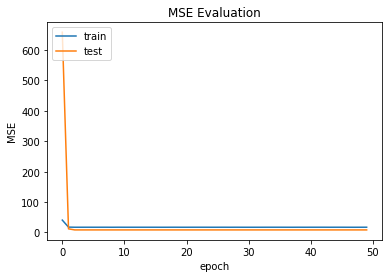

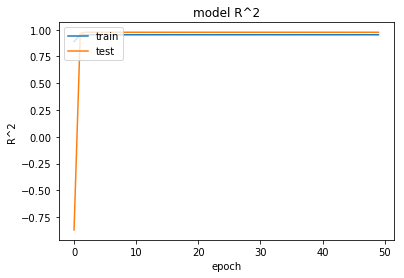

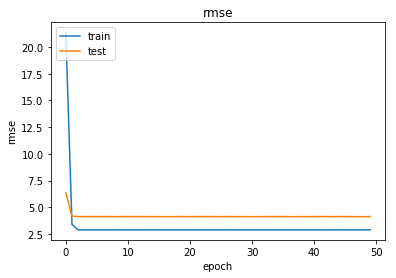

In [9]:
# plot training curve for MSE
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('MSE Evaluation')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# plot training curve for R^2 (beware of scale, starts very low negative)
plt.plot(history.history['val_r_square'])
plt.plot(history.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
           
# plot training curve for rmse
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
# Performance on training data
import sklearn.metrics, math

y_pred = estimator.predict(train_data)

# Gets us to 68th position on Kaggle, but just based on training data...
print("Root mean squared error (RMSE): %f" % math.sqrt(sklearn.metrics.mean_squared_error(y_train,y_pred)))
print("R square (R^2):                 %f" % sklearn.metrics.r2_score(y_train,y_pred))

Root mean squared error (RMSE): 3.201663
R square (R^2):                 -0.007027


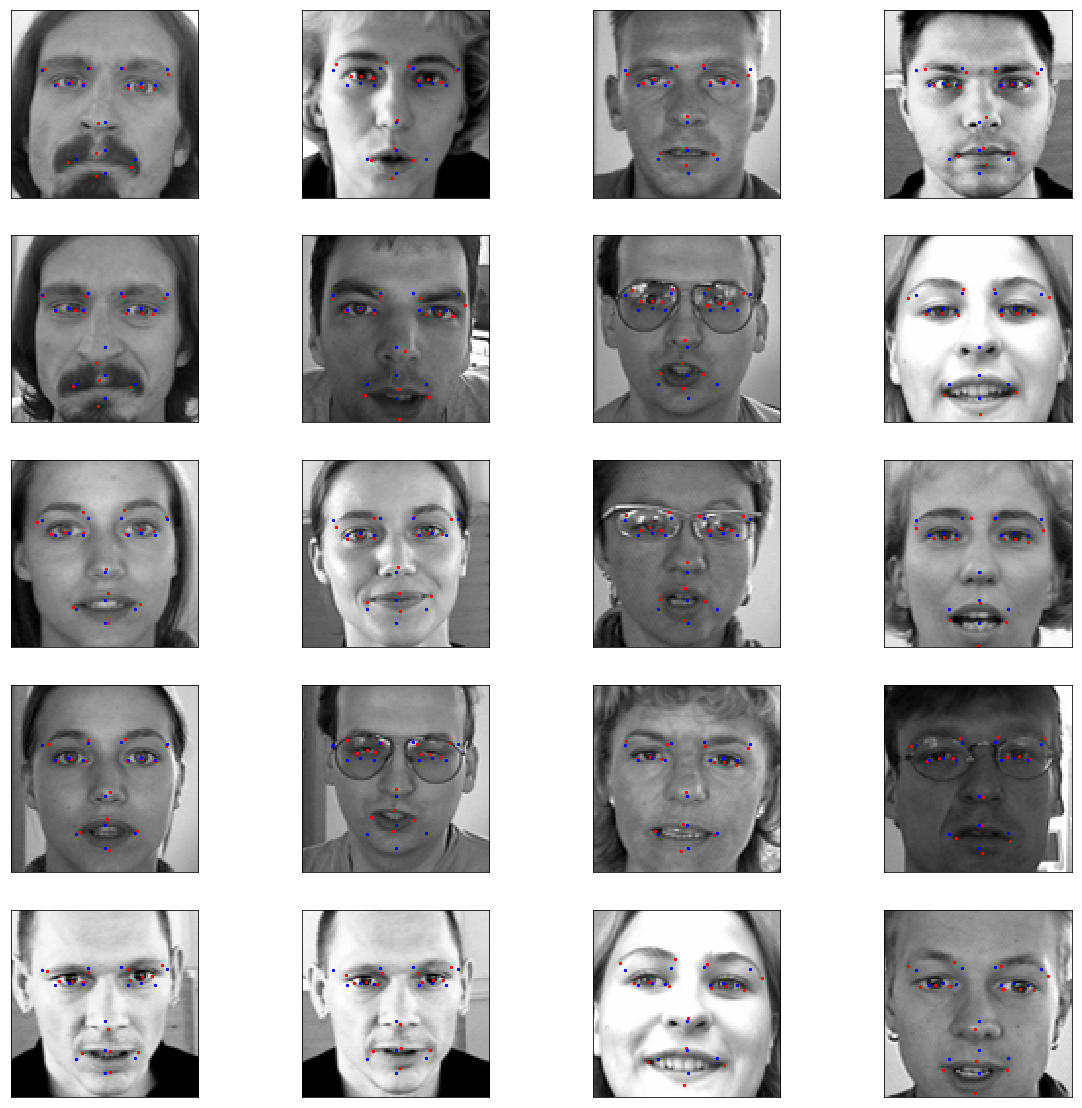

In [11]:
# Plotting some of the image data with keypoints
position = 1

fig = plt.figure(figsize = (20, 20))

for index in range(20):
    sub = fig.add_subplot(5, 4, position)
    plt.imshow(np.reshape(np.array(kaggle_train.iloc[index,:].astype(int)), (96, 96)), cmap = 'gray')
    
    for coord in range(0, labels.iloc[index,:].shape[0]-1, 2):
        if coord == None:
            continue
        else:
            plt.gca().scatter(labels.iloc[index,coord], labels.iloc[index,coord+1], c = 'red', s = 5)
    
    for coord in range(0, y_pred[index,:].shape[0]-1, 2):
        if coord == None:
            continue
        else:
            plt.gca().scatter(y_pred[index,coord], y_pred[index,coord+1], c = 'blue', s = 5)

    sub.set_xticks([])
    sub.set_yticks([])
    
    position += 1

plt.show()